## Glossary
* tbss problem: two-basestation-sensor problem
* bs: basestation (also referred to as cameras, analogous to a camera in photogrammetry)
* baseline: line between the two basestations
* fov: field of view
* world: Our mathematical model of the world. Presumably contains the positions of the BSes and sensors.
* baseline: the vector between the optical centers of our two lighthouses

**Note: This is very very similar to photogrammetry in several areas, and a lot of the ideas, solutions and terminology is taken from that field.**

## TBSS problem
The TBSS problem consists of two BSes at random positions and rotations. Due to real life physics, BS positions cannot be coincident.

The TBSS problem is a problem of 5 unknowns:
* 3 variables in relative orientation between the BSes.
* 2 variables in the baseline

There are several things we can't figure out without any further infomation:
* The down direction in the world. This can be constrained by getting a single reference down direction.
* The scale of the world. This can be constrained by getting the distance between two measured points in the world. (BS to sensor, sensor to sensor, BS to BS)

### Base station down vector
**As is, it seems like the down vector only has one working axis. The other two are broken. While the one dimention can still be used, it doesn't provide many advantages, and I probably won't bother.**

As it turns out, the ootx block gives us a down vector for both BSes. This can be utilized to reduce the unknowns by 2, and constrain the absolute orientation to our world.

When we constrain the rotation of a single BS at an axis, we reduce the 3 unknowns in the orientation of the BS to 1 (the rotation around that axis). Since the down vector of the first BS and second BS should be parallel, this will constrain the relative orientation of the two BSes to 1 axis.

This will reduce our total number of variables to solve for to 3.

### Improvements
Because the TBSS problem only considers one sample point, we lose some potentially useful information in systems with multiple sensors.

If the geometric relationships between different sensors in the system are known, this knowledge can be applied as constraints when solving the system.

## Working towards a solution to the TBSS problem

### Coplanarity condition

The central theorem we will be using is the coplanarity condition.

If we have one ray coming out of BS A $x_a$ and hitting a point, and another ray from BS B $x_b$ and hitting the same point, we observe that $x_a$, $x_b$ and the basis vector $B$ will lie on the same plane.

When three vectors lie on a plane, the triple product of the three will be equal to zero. We can hence state that when our three vectors $x_a$, $x_b$ and $B$ lie on a plane, they will satisfy $[x_a x_b B] = x_a \cdot (x_b \times B) = 0$.


## Context

This is the procedure I came up with a solution of the essential matrix.

Please note that my use-case is a bit of a special case compared to regular photogrammetry, namely. This is not very important, and is only meant to give some context:
* "Cameras" are not actually cameras. They are a pair of laser beacons which are fixed at random positions and rotations around the room.
* For each observed point, each of the the two beacons perform two scans, one horizontal and one vectical.
* Given two laser scans from each of the two beacons, we are effectively given a pitch and yaw angle from both of the beacons.
* The pitch and yaw observation from each beacon is converted to a homogenous coordinate using $p = \begin{bmatrix} sin(o_{pitch}) && -sin(o_{yaw}) \times cos(o_{pitch}) && cos(o_{yaw}) \times cos(o_{pitch}) \end{bmatrix}^T$ where $o$ is the raw observation
* **Each of the beacons is fully calibrated, and there are no "intrinsics" that need to be estimated.**

## Procedure


### Initial estimate of Fundimental matrix
1. $p'Fp=0$ is our observation equation, where $p'$ is the ray from the left and $p$ is the ray from the right camera (both in homogenous coordinates).
2. Rewrite $p'Fp=0$ into the form $Gf=0$, where $f$ is the column vector form of $F$, and $G$ is a row vector.
3. Add all points we want to solve for to $G$ in the form
$$G = \begin{bmatrix}
x_0x'_0 & x_0y'_0 & x_0 & y_0x'_0 & y_0y'_0 & y_0 & x'_0 & y'_0 & 1 \\
\vdots \\
x_nx'_n & x_ny'_n & x_n & y_nx'_n & y_ny'_n & y_n & x'_n & y'_n & 1
\end{bmatrix}$$
4. Find a least squares non trivial solution to $Gf=0$ using SVD.
5. (Possibly enforce rank 2 of the matrix using SVD and setting smallest singular value to 0?)
6. $F$ is our initial solution to the fundimental matrix

### Iterative numerical optimization of estimate to Essential matrix
1. The essential matrix is defined as a 3x3 matrix $E$ with the following two constraints:
    1. $|E| = 0$
    2. $2EE^TE - tr(EE^T)E = 0$
2. Set our initial estimate $e_0 = F$ from above. 
3. Introduce the two constraints to an equation using lagrange multipliers:
$$f(E) = (Ge)^TGe + \sigma_1|E|^2 + \sigma_2(2EE^TE-tr(EE^T)E)^2$$
4. Calculate $\frac{\Delta f}{\Delta E}$, and utilize to numerically optimize
5. Since we presume our estimate is relatively close to our final solution, I would think using Gauss-Newton is good enough? (Right now I am just doing gradient descent as a test, which seems to work relatively well, although too slow for my use in general)


## Questions

* I think my general approach makes at least some sense. When testing on real data, I get a fair solution to F using the first part. The second part seems to improve the solution, and my residual drops very small after some iterations. Extracting a rotation matrix and translation, and doing ray-ray intersection does produce nice looking data.
* Is there anything I seem to have misunderstood or that looks iffy?
* There is not a lot of information on the internet as to how lagrange multipliers are best applied when doing numerical opsimization. I am using 1 as my initial condition for both lagrange multipliers. Does this make sense? Are there better ways of doing it?
* Right now I am using sympy for deriving equations and numpy/scipy for initial implementation. I have heard good things about mathematica for doing exploration like this, is it recommended?

## Random stuff used in derivations

### Length of vector squared
Used to simplify $(Ge)^TGe$ into something easily computable.
$$||\vec{a_n}||^2 = \sqrt{\sum_{i=1}^{n} a_i^2}^2 = \sum_{i=1}^{n} a_i^2$$

In [2]:
from sympy import Matrix, MatrixSymbol, Function
from sympy import Symbol, Eq, Trace, sqrt
from sympy import init_printing, sympify
from sympy.matrices import eye
init_printing()
from IPython.display import display, Markdown, Latex

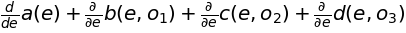

In [3]:
e = Symbol('e')
o1 = Symbol('o1')
o2 = Symbol('o2')
o3 = Symbol('o3')

a = Function('a')(e)
b = Function('b')(e, o1)
c = Function('c')(e, o2)
d = Function('d')(e, o3)

f = a + b + c + d

f.diff(e)

In [4]:
Es = MatrixSymbol('E', 3, 3)
E = Matrix(Es)
e = Matrix(list(E))

o1 = Symbol('o1')
o2 = Symbol('o2')

Y = MatrixSymbol('Y', 5, 9)
Yi = Matrix(MatrixSymbol('Y', 1, 9))

In [5]:
display(Markdown("## Derivative of a(e)"))

print("Diff e0")
display(Matrix(Y*e).diff(Matrix(e)[0]).transpose())
print("Diff e1")
display(Matrix(Y*e).diff(Matrix(e)[1]).transpose())

eq_a_i_v = Yi*e
assert(len(eq_a_i_v) == 1)

eq_a_i = (eq_a_i_v[0]*eq_a_i_v[0])
eq_a_i

## Derivative of a(e)

Diff e0


[Y₀₀  Y₁₀  Y₂₀  Y₃₀  Y₄₀]

Diff e1


[Y₀₁  Y₁₁  Y₂₁  Y₃₁  Y₄₁]

In [6]:
display(Markdown("## Derivative of b(e, o1)"))

#E = MatrixSymbol('E', 3, 3)

eq_b = (o1*E.det()**2)
eq_b.diff(o1)

## Derivative of b(e, o1)

In [7]:
display(Markdown("## c(e, o2)"))

m = Matrix(Es*Es.transpose()).expand()
mm = Matrix([
        [m[0], 0, 0],
        [0, m[4], 0],
        [0, 0, m[8]]
    ])

mmm = Matrix((((2*Es*Es.transpose()*Es) - mm*Es))).expand()

mmmm = 0
for thing in mmm:
    mmmm = mmmm + thing**2

eq_c = (o2*sqrt(mmmm)**2).simplify()
eq_c.diff(E[1])

## c(e, o2)

In [14]:
display(Markdown("## d(e, o3)"))

#E = MatrixSymbol('E', 3, 3)

m = Matrix(Es*Es.transpose()).expand()
display(m)

mm = ((m[0] + m[4] + m[8]) - 1)**2
display(mm)

eq_d = (o1*mm).simplify()
eq_d.diff(E[1])

## d(e, o3)

⎡       2      2      2                                                       
⎢    E₀₀  + E₀₁  + E₀₂        E₀₀⋅E₁₀ + E₀₁⋅E₁₁ + E₀₂⋅E₁₂  E₀₀⋅E₂₀ + E₀₁⋅E₂₁ +
⎢                                                                             
⎢                                    2      2      2                          
⎢E₀₀⋅E₁₀ + E₀₁⋅E₁₁ + E₀₂⋅E₁₂      E₁₀  + E₁₁  + E₁₂        E₁₀⋅E₂₀ + E₁₁⋅E₂₁ +
⎢                                                                             
⎢                                                                 2      2    
⎣E₀₀⋅E₂₀ + E₀₁⋅E₂₁ + E₀₂⋅E₂₂  E₁₀⋅E₂₀ + E₁₁⋅E₂₁ + E₁₂⋅E₂₂      E₂₀  + E₂₁  + E

        ⎤
 E₀₂⋅E₂₂⎥
        ⎥
        ⎥
 E₁₂⋅E₂₂⎥
        ⎥
  2     ⎥
₂₂      ⎦

In [15]:
from sympy.utilities.codegen import codegen
from sympy.printing.lambdarepr import lambdarepr

expr = (eq_a_i + eq_b + eq_c)

args = list(e)
args.append(o1)
args.append(o2)

#list(map(lambda a: expr.diff(a), args))

funs = [
    ('eqa', eq_a_i),
    ('eqa_d_e0', eq_a_i.diff(e[0])),
    ('eqa_d_e1', eq_a_i.diff(e[1])),
    ('eqa_d_e2', eq_a_i.diff(e[2])),
    ('eqa_d_e3', eq_a_i.diff(e[3])),
    ('eqa_d_e4', eq_a_i.diff(e[4])),
    ('eqa_d_e5', eq_a_i.diff(e[5])),
    ('eqa_d_e6', eq_a_i.diff(e[6])),
    ('eqa_d_e7', eq_a_i.diff(e[7])),
    ('eqa_d_e8', eq_a_i.diff(e[8])),
    ('eqb', eq_b),
    ('eqb_d_e0', eq_b.diff(e[0])),
    ('eqb_d_e1', eq_b.diff(e[1])),
    ('eqb_d_e2', eq_b.diff(e[2])),
    ('eqb_d_e3', eq_b.diff(e[3])),
    ('eqb_d_e4', eq_b.diff(e[4])),
    ('eqb_d_e5', eq_b.diff(e[5])),
    ('eqb_d_e6', eq_b.diff(e[6])),
    ('eqb_d_e7', eq_b.diff(e[7])),
    ('eqb_d_e8', eq_b.diff(e[8])),
    ('eqc', eq_c),
    ('eqc_d_e0', eq_c.diff(e[0])),
    ('eqc_d_e1', eq_c.diff(e[1])),
    ('eqc_d_e2', eq_c.diff(e[2])),
    ('eqc_d_e3', eq_c.diff(e[3])),
    ('eqc_d_e4', eq_c.diff(e[4])),
    ('eqc_d_e5', eq_c.diff(e[5])),
    ('eqc_d_e6', eq_c.diff(e[6])),
    ('eqc_d_e7', eq_c.diff(e[7])),
    ('eqc_d_e8', eq_c.diff(e[8])),
    ('eqd', eq_d),
    ('eqd_d_e0', eq_d.diff(e[0])),
    ('eqd_d_e1', eq_d.diff(e[1])),
    ('eqd_d_e2', eq_d.diff(e[2])),
    ('eqd_d_e3', eq_d.diff(e[3])),
    ('eqd_d_e4', eq_d.diff(e[4])),
    ('eqd_d_e5', eq_d.diff(e[5])),
    ('eqd_d_e6', eq_d.diff(e[6])),
    ('eqd_d_e7', eq_d.diff(e[7])),
    ('eqd_d_e8', eq_d.diff(e[8])),
]

#print(codegen(funs, 'c', 'essential_matrix_eqs', to_files=True))

out_py = ""
for (fun_name, fun_expr) in funs:
    out_py += fun_name + " = lambda E, Y, o1, o2, o3: " + lambdarepr(fun_expr) + "\n"
with open('funs.py', 'w') as f:
    f.write(out_py)

#expr_rout = codegen.Routine('lol', args)